In [1]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline


# TorchVision Object Detection Finetuning Tutorial


For this tutorial, we will be finetuning a pre-trained [Mask
R-CNN](https://arxiv.org/abs/1703.06870) model on the [Penn-Fudan
Database for Pedestrian Detection and
Segmentation](https://www.cis.upenn.edu/~jshi/ped_html/). It contains
170 images with 345 instances of pedestrians, and we will use it to
illustrate how to use the new features in torchvision in order to train
an object detection and instance segmentation model on a custom dataset.


.. note ::

    This tutorial works only with torchvision version >=0.16 or nightly.
    If you're using torchvision<=0.15, please follow
    [this tutorial instead](https://github.com/pytorch/tutorials/blob/d686b662932a380a58b7683425faa00c06bcf502/intermediate_source/torchvision_tutorial.rst).


## Defining the Dataset

The reference scripts for training object detection, instance
segmentation and person keypoint detection allows for easily supporting
adding new custom datasets. The dataset should inherit from the standard
:class:`torch.utils.data.Dataset` class, and implement ``__len__`` and
``__getitem__``.

The only specificity that we require is that the dataset ``__getitem__``
should return a tuple:

-  image: :class:`torchvision.tv_tensors.Image` of shape ``[3, H, W]``, a pure tensor, or a PIL Image of size ``(H, W)``
-  target: a dict containing the following fields

   -  ``boxes``, :class:`torchvision.tv_tensors.BoundingBoxes` of shape ``[N, 4]``:
      the coordinates of the ``N`` bounding boxes in ``[x0, y0, x1, y1]`` format, ranging from ``0``
      to ``W`` and ``0`` to ``H``
   -  ``labels``, integer :class:`torch.Tensor` of shape ``[N]``: the label for each bounding box.
      ``0`` represents always the background class.
   -  ``image_id``, int: an image identifier. It should be
      unique between all the images in the dataset, and is used during
      evaluation
   -  ``area``, float :class:`torch.Tensor` of shape ``[N]``: the area of the bounding box. This is used
      during evaluation with the COCO metric, to separate the metric
      scores between small, medium and large boxes.
   -  ``iscrowd``, uint8 :class:`torch.Tensor` of shape ``[N]``: instances with ``iscrowd=True`` will be
      ignored during evaluation.
   -  (optionally) ``masks``, :class:`torchvision.tv_tensors.Mask` of shape ``[N, H, W]``: the segmentation
      masks for each one of the objects

If your dataset is compliant with above requirements then it will work for both
training and evaluation codes from the reference script. Evaluation code will use scripts from
``pycocotools`` which can be installed with ``pip install pycocotools``.

.. note ::
  For Windows, please install ``pycocotools`` from [gautamchitnis](https://github.com/gautamchitnis/cocoapi) with command

  ``pip install git+https://github.com/gautamchitnis/cocoapi.git@cocodataset-master#subdirectory=PythonAPI``

One note on the ``labels``. The model considers class ``0`` as background. If your dataset does not contain the background class,
you should not have ``0`` in your ``labels``. For example, assuming you have just two classes, *cat* and *dog*, you can
define ``1`` (not ``0``) to represent *cats* and ``2`` to represent *dogs*. So, for instance, if one of the images has both
classes, your ``labels`` tensor should look like ``[1, 2]``.

Additionally, if you want to use aspect ratio grouping during training
(so that each batch only contains images with similar aspect ratios),
then it is recommended to also implement a ``get_height_and_width``
method, which returns the height and the width of the image. If this
method is not provided, we query all elements of the dataset via
``__getitem__`` , which loads the image in memory and is slower than if
a custom method is provided.

### Writing a custom dataset for PennFudan

Let’s write a dataset for the PennFudan dataset. First, let's download the dataset and
extract the [zip file](https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip):

.. code:: python

    wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip -P data
    cd data && unzip PennFudanPed.zip


We have the following folder structure:

::

   PennFudanPed/
     PedMasks/
       FudanPed00001_mask.png
       FudanPed00002_mask.png
       FudanPed00003_mask.png
       FudanPed00004_mask.png
       ...
     PNGImages/
       FudanPed00001.png
       FudanPed00002.png
       FudanPed00003.png
       FudanPed00004.png

Here is one example of a pair of images and segmentation masks



/d/pfournie/dl_toolbox/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


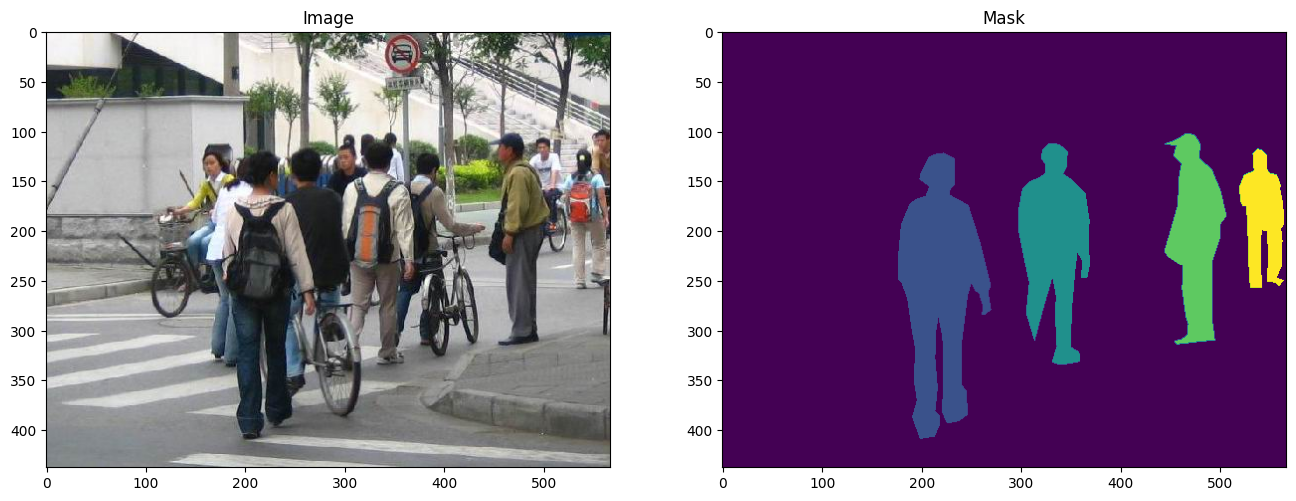

In [2]:
import matplotlib.pyplot as plt
from torchvision.io import read_image


image = read_image("/data/PennFudanPed/PNGImages/FudanPed00046.png")
mask = read_image("/data/PennFudanPed/PedMasks/FudanPed00046_mask.png")

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.title("Image")
plt.imshow(image.permute(1, 2, 0))
plt.subplot(122)
plt.title("Mask")
plt.imshow(mask.permute(1, 2, 0))

So each image has a corresponding
segmentation mask, where each color correspond to a different instance.
Let’s write a :class:`torch.utils.data.Dataset` class for this dataset.
In the code below, we are wrapping images, bounding boxes and masks into
:class:`torchvision.tv_tensors.TVTensor` classes so that we will be able to apply torchvision
built-in transformations ([new Transforms API](https://pytorch.org/vision/stable/transforms.html))
for the given object detection and segmentation task.
Namely, image tensors will be wrapped by :class:`torchvision.tv_tensors.Image`, bounding boxes into
:class:`torchvision.tv_tensors.BoundingBoxes` and masks into :class:`torchvision.tv_tensors.Mask`.
As :class:`torchvision.tv_tensors.TVTensor` are :class:`torch.Tensor` subclasses, wrapped objects are also tensors and inherit the plain
:class:`torch.Tensor` API. For more information about torchvision ``tv_tensors`` see
[this documentation](https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_getting_started.html#what-are-tvtensors).



In [3]:
import os
import torch

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = read_image(img_path)
        mask = read_image(mask_path)
        # instances are encoded as different colors
        obj_ids = torch.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        # split the color-encoded mask into a set
        # of binary masks
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # get bounding box coordinates for each mask
        boxes = masks_to_boxes(masks)

        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

That’s all for the dataset. Now let’s define a model that can perform
predictions on this dataset.

## Defining your model

In this tutorial, we will be using [Mask
R-CNN](https://arxiv.org/abs/1703.06870), which is based on top of
[Faster R-CNN](https://arxiv.org/abs/1506.01497). Faster R-CNN is a
model that predicts both bounding boxes and class scores for potential
objects in the image.

<img src="file://../../_static/img/tv_tutorial/tv_image03.png">

Mask R-CNN adds an extra branch
into Faster R-CNN, which also predicts segmentation masks for each
instance.

<img src="file://../../_static/img/tv_tutorial/tv_image04.png">

There are two common
situations where one might want
to modify one of the available models in TorchVision Model Zoo. The first
is when we want to start from a pre-trained model, and just finetune the
last layer. The other is when we want to replace the backbone of the
model with a different one (for faster predictions, for example).

Let’s go see how we would do one or another in the following sections.

### 1 - Finetuning from a pretrained model

Let’s suppose that you want to start from a model pre-trained on COCO
and want to finetune it for your particular classes. Here is a possible
way of doing it:



In [4]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

### 2 - Modifying the model to add a different backbone



In [5]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
# ``FasterRCNN`` needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),)
)

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# ``OrderedDict[Tensor]``, and in ``featmap_names`` you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=['0'],
    output_size=7,
    sampling_ratio=2
)

# put the pieces together inside a Faster-RCNN model
model = FasterRCNN(
    backbone,
    num_classes=2,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
)

### Object detection and instance segmentation model for PennFudan Dataset

In our case, we want to finetune from a pre-trained model, given that
our dataset is very small, so we will be following approach number 1.

Here we want to also compute the instance segmentation masks, so we will
be using Mask R-CNN:



In [6]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    return model

That’s it, this will make ``model`` be ready to be trained and evaluated
on your custom dataset.

## Putting everything together

In ``references/detection/``, we have a number of helper functions to
simplify training and evaluating detection models. Here, we will use
``references/detection/engine.py`` and ``references/detection/utils.py``.
Just download everything under ``references/detection`` to your folder and use them here.
On Linux if you have ``wget``, you can download them using below commands:



In [ ]:
import os 
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

Since v0.15.0 torchvision provides [new Transforms API](https://pytorch.org/vision/stable/transforms.html)
to easily write data augmentation pipelines for Object Detection and Segmentation tasks.

Let’s write some helper functions for data augmentation /
transformation:



In [8]:
from torchvision.transforms import v2 as T


def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

## Testing ``forward()`` method (Optional)

Before iterating over the dataset, it's good to see what the model
expects during training and inference time on sample data.



In [9]:
import utils


model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
dataset = PennFudanDataset('/data/PennFudanPed', get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=4,
    collate_fn=utils.collate_fn
)

# For Training
images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets)  # Returns losses and detections
print(output)

# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)  # Returns predictions
print(predictions[0])

{'loss_classifier': tensor(0.1369, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0375, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0517, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0019, grad_fn=<DivBackward0>)}
{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}


Let’s now write the main function which performs the training and the
validation:



In [14]:
# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
dataset = PennFudanDataset('/data/PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('/data/PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=4,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    collate_fn=utils.collate_fn
)


In [ ]:
class FasterRCNN(pl.LightningModule):
    def __init__(
        self,
        network,
        num_classes,
        optimizer,
        scheduler,
        loss,
        batch_tf,
        metric_ignore_index,
        norm,
        one_hot,
        tta=None,
        sliding=None,
        *args,
        **kwargs
    ):
        super().__init__()
        self.network = get_model_instance_segmentation(num_classes)
        #self.network = network(in_channels=in_channels, num_classes=num_classes)
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.num_classes = num_classes
        self.loss = loss
        self.batch_tf = batch_tf
        self.tta = tta
        self.sliding = sliding
        self.norm = norm
        self.one_hot = one_hot
        coco = get_coco_api_from_dataset(data_loader.dataset)
        iou_types = _get_iou_types(model)
        self.coco_evaluator = CocoEvaluator(coco, iou_types)
    
    def configure_optimizers(self):
        parameters = list(self.parameters())
        trainable_parameters = list(filter(lambda p: p.requires_grad, parameters))
        optimizer = self.optimizer(params=trainable_parameters)
        scheduler = self.scheduler(optimizer)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "epoch"
            },
        }
    
    def training_step(self, batch, batch_idx):
        batch = batch["sup"]
        x = batch["image"]
        y = batch["label"]
        loss_dict = self.network(x,y)
        loss = sum(loss for loss in loss_dict.values())
        self.log(f"{self.loss.__name__}/train", loss)
        return loss
        
    def validation_step(self, batch, batch_idx):
        x = batch["image"]
        y = batch["label"]
        outputs = self.network(x)
        outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
        res = {target["image_id"]: output for target, output in zip(targets, outputs)}
        coco_evaluator.update(res)
        
    def on_validation_epoch_end(self):
        self.log("accuracy/val", self.val_accuracy.compute())
        self.log("iou/val", self.val_jaccard.compute())
        confmat = self.val_cm.compute().detach().cpu()
        self.val_accuracy.reset()
        self.val_jaccard.reset()
        self.val_cm.reset()
        class_names = self.trainer.datamodule.class_names
        logger = self.trainer.logger
        fs = 12 - 2*(self.num_classes//10)
        fig = plot_confusion_matrix(confmat, class_names, norm=None, fontsize=fs)
        logger.experiment.add_figure("confmat/val", fig, global_step=self.trainer.global_step)

        if self.one_hot: y = self.to_one_hot(y)
        logits_x = self.forward(x, sliding=self.sliding)                    
        loss = self.loss(logits_x, y)
        self.log(f"{self.loss.__name__}/val", loss)
        probs = self.loss.prob(logits_x)
        preds = self.loss.pred(probs)
        self.val_accuracy.update(preds, y)
        self.val_cm.update(preds, y)
        self.val_jaccard.update(preds, y)

In [11]:
from engine import train_one_epoch, evaluate

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

module = FasterRCNN(
    network,
    in_channels=3,
    num_classes=,
    optimizer,
    scheduler,
    loss,
    batch_tf,
    metric_ignore_index,
    norm,
    one_hot,
    tta=None,
    sliding=None,
    *args,
    **kwargs
)
# let's train it just for 2 epochs
num_epochs = 2

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("That's it!")

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /d/pfournie/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 170M/170M [00:02<00:00, 69.2MB/s]


Epoch: [0]  [ 0/60]  eta: 0:10:29  lr: 0.000090  loss: 4.3565 (4.3565)  loss_classifier: 0.6228 (0.6228)  loss_box_reg: 0.3342 (0.3342)  loss_mask: 3.3791 (3.3791)  loss_objectness: 0.0175 (0.0175)  loss_rpn_box_reg: 0.0029 (0.0029)  time: 10.4884  data: 0.2495
Epoch: [0]  [10/60]  eta: 0:07:49  lr: 0.000936  loss: 1.5356 (2.3175)  loss_classifier: 0.4008 (0.4059)  loss_box_reg: 0.2970 (0.3083)  loss_mask: 0.9630 (1.5811)  loss_objectness: 0.0160 (0.0182)  loss_rpn_box_reg: 0.0043 (0.0041)  time: 9.3909  data: 0.0245
Epoch: [0]  [20/60]  eta: 0:06:21  lr: 0.001783  loss: 0.8181 (1.5098)  loss_classifier: 0.1922 (0.2776)  loss_box_reg: 0.2854 (0.2764)  loss_mask: 0.3059 (0.9349)  loss_objectness: 0.0119 (0.0165)  loss_rpn_box_reg: 0.0038 (0.0045)  time: 9.4972  data: 0.0023
Epoch: [0]  [30/60]  eta: 0:04:50  lr: 0.002629  loss: 0.6046 (1.2289)  loss_classifier: 0.0986 (0.2178)  loss_box_reg: 0.2372 (0.2732)  loss_mask: 0.2252 (0.7131)  loss_objectness: 0.0182 (0.0187)  loss_rpn_box_reg:

So after one epoch of training, we obtain a COCO-style mAP > 50, and
a mask mAP of 65.

But what do the predictions look like? Let’s take one image in the
dataset and verify




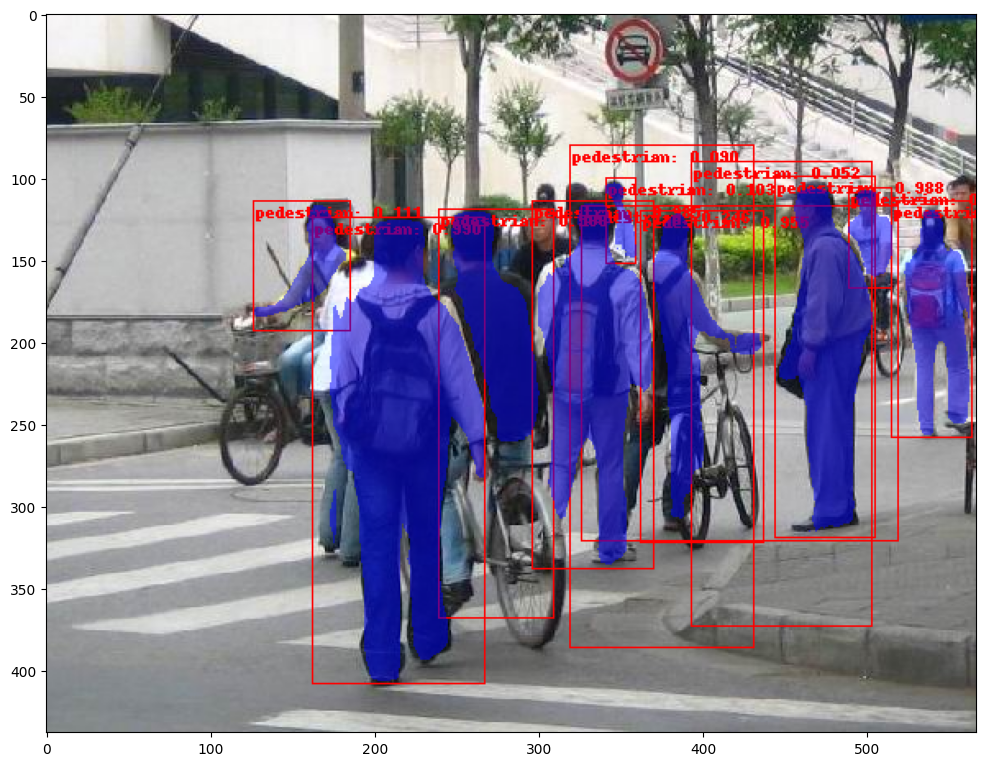

In [13]:
import matplotlib.pyplot as plt

from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks


image = read_image("/data/PennFudanPed/PNGImages/FudanPed00046.png")
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]


image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"pedestrian: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

masks = (pred["masks"] > 0.7).squeeze(1)
output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")


plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))

The results look good!

## Wrapping up

In this tutorial, you have learned how to create your own training
pipeline for object detection models on a custom dataset. For
that, you wrote a :class:`torch.utils.data.Dataset` class that returns the
images and the ground truth boxes and segmentation masks. You also
leveraged a Mask R-CNN model pre-trained on COCO train2017 in order to
perform transfer learning on this new dataset.

For a more complete example, which includes multi-machine / multi-GPU
training, check ``references/detection/train.py``, which is present in
the torchvision repository.




In [2]:
from torch import BoolTensor, IntTensor, Tensor
from torchmetrics.detection.mean_ap import MeanAveragePrecision

# Preds should be a list of elements, where each element is a dict
# containing 3 keys: boxes, scores, labels
mask_pred = [
    [0, 0, 0, 0, 0],
    [0, 0, 1, 1, 0],
    [0, 0, 1, 1, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
]
preds = [
    {
        # The boxes keyword should contain an [N,4] tensor,
        # where N is the number of detected boxes with boxes of the format
        # [xmin, ymin, xmax, ymax] in absolute image coordinates
        "boxes": Tensor([[258.0, 41.0, 606.0, 285.0]]),
        # The scores keyword should contain an [N,] tensor where
        # each element is confidence score between 0 and 1
        "scores": Tensor([0.536]),
        # The labels keyword should contain an [N,] tensor
        # with integers of the predicted classes
        "labels": IntTensor([0]),
        # The masks keyword should contain an [N,H,W] tensor,
        # where H and W are the image height and width, respectively,
        # with boolean masks. This is only required when iou_type is `segm`.
        "masks": BoolTensor([mask_pred]),
    }
]

# Target should be a list of elements, where each element is a dict
# containing 2 keys: boxes and labels (and masks, if iou_type is `segm`).
# Each keyword should be formatted similar to the preds argument.
# The number of elements in preds and target need to match
mask_tgt = [
    [0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0],
    [0, 0, 1, 1, 0],
    [0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0],
]
target = [
    {
        "boxes": Tensor([[214.0, 41.0, 562.0, 285.0]]),
        "labels": IntTensor([0]),
        "masks": BoolTensor([mask_tgt]),
    }
]

if __name__ == "__main__":
    # Initialize metric
    metric = MeanAveragePrecision(iou_type="segm")

    # Update metric with predictions and respective ground truth
    metric.update(preds, target)

    # Compute the results
    result = metric.compute()
    print(result)

{'map': tensor(0.2000), 'map_50': tensor(1.), 'map_75': tensor(0.), 'map_small': tensor(0.2000), 'map_medium': tensor(-1.), 'map_large': tensor(-1.), 'mar_1': tensor(0.2000), 'mar_10': tensor(0.2000), 'mar_100': tensor(0.2000), 'mar_small': tensor(0.2000), 'mar_medium': tensor(-1.), 'mar_large': tensor(-1.), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.)}
